# Notebook 03 — Robust Research (Walk-forward + IC)

Objetivo:
- Treinar um modelo **regressivo** para prever `future_ret_m` (retorno futuro mensal ~21 pregões)
- Gerar previsões **verdadeiramente out-of-sample** via walk-forward (expanding window)
- Avaliar a qualidade do ranking com métricas de mercado:
  - IC mensal (Spearman)
  - IC médio e IC IR (Information Ratio)

Saída deste notebook:
- `data/processed/preds_oos.parquet` contendo:
  - date, ticker, y_true (future_ret_m), y_pred
  - fold/periodo
  - features usadas (opcional)

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

DATA_PATH = "../data/processed/ibov_top40_features.parquet"
OUT_PATH = "../data/processed/preds_oos.parquet"

H = 21  # horizonte mensal (pregões)
MIN_TRAIN_YEARS = 5  # mínimo de anos no treino antes de começar a testar
TEST_FREQ = "M"  # test por mês (rebalanceamento mensal)
K_DEBUG = 5  # só para diagnósticos rápidos (não é backtest ainda)

In [8]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Não encontrei {DATA_PATH}. Rode: python -m src.features")

df = pd.read_parquet(DATA_PATH).copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "ticker", "adj_close"]).copy()
df["ticker"] = df["ticker"].astype(str).str.upper().str.strip()

# Garantir ordenação
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

# Se future_ret_m não existir, recria (não muda o dataset salvo, só aqui no notebook)
if "future_ret_m" not in df.columns:
    df["future_ret_m"] = df.groupby("ticker")["adj_close"].shift(-H) / df["adj_close"] - 1

# Remover linhas onde não dá para calcular o target
df = df.dropna(subset=["future_ret_m"]).copy()

print("Shape:", df.shape)
print("Datas:", df["date"].min(), "->", df["date"].max())
print("Tickers:", df["ticker"].nunique())
df.head()

Shape: (175299, 38)
Datas: 2000-02-02 03:00:00 -> 2026-01-16 03:00:00
Tickers: 38


,date,ticker,open,high,low,close,volume,adjustedClose,adj_close,ret_1d,logret_1d,mom_5d,mom_21d,mom_63d,mom_126d,mom_252d,ma_10,price_to_ma_10,ma_21,price_to_ma_21,ma_63,price_to_ma_63,ma_126,price_to_ma_126,ma_252,price_to_ma_252,vol_10,vol_21,vol_63,logvol,logvol_z_63,hl_range,oc_change,rsi_14,future_ret_w,target_w,future_ret_m,target_m
0,2000-02-24 03:00:00,ABEV3,0.3020,0.3020,0.2960,0.2960,66000,0.1811,0.1811,-0.013079,-0.013165,-0.063114,-0.063114,NaN,NaN,NaN,0.18146,-0.001984,0.186267,-0.027738,NaN,NaN,NaN,NaN,NaN,NaN,0.109732,0.100647,NaN,11.097410,NaN,0.020270,-0.019868,37.733972,0.013252,1,0.310878,1
1,2000-02-25 03:00:00,ABEV3,0.2920,0.2920,0.2880,0.2880,40000,0.1762,0.1762,-0.027057,-0.027430,-0.052688,-0.039782,NaN,NaN,NaN,0.18122,-0.027701,0.185919,-0.052276,NaN,NaN,NaN,NaN,NaN,NaN,0.045961,0.100191,NaN,10.596635,NaN,0.013889,-0.013699,36.415246,0.041430,1,0.385925,1
2,2000-02-29 03:00:00,ABEV3,0.2880,0.2880,0.2840,0.2840,153000,0.1737,0.1737,-0.014188,-0.014290,-0.090100,-0.053406,NaN,NaN,NaN,0.18122,-0.041497,0.185452,-0.063371,NaN,NaN,NaN,NaN,NaN,NaN,0.045289,0.100226,NaN,11.938193,NaN,0.014085,-0.013889,35.729169,0.070812,1,0.394934,1
3,2000-03-03 03:00:00,ABEV3,0.3112,0.3112,0.3112,0.3112,10000,0.1904,0.1904,0.096143,0.091797,0.057190,0.037602,NaN,NaN,NaN,0.18289,0.041063,0.185781,0.024863,NaN,NaN,NaN,NaN,NaN,NaN,0.053794,0.102325,NaN,9.210340,NaN,0.000000,0.000000,43.400394,-0.023109,0,0.272584,1
4,2000-03-09 03:00:00,ABEV3,0.3160,0.3200,0.3160,0.3200,26000,0.1958,0.1958,0.028361,0.027967,0.067030,0.067030,NaN,NaN,NaN,0.18510,0.057807,0.186367,0.050617,NaN,NaN,NaN,NaN,NaN,NaN,0.053990,0.102483,NaN,10.165852,NaN,0.012658,0.012658,45.659000,-0.050051,0,0.124617,1


In [9]:
# Features base (as mesmas do baseline, para controlar comparação)
core_features = [
    "ret_1d", "logret_1d",
    "mom_5d", "mom_21d", "mom_63d",
    "price_to_ma_10", "price_to_ma_21", "price_to_ma_63",
    "vol_10", "vol_21", "vol_63",
    "hl_range", "oc_change",
    "logvol_z_63",
    "rsi_14",
]

features = [c for c in core_features if c in df.columns]
print("N features:", len(features))
print("Features:", features)

# Segurança: remover inf
df[features] = df[features].replace([np.inf, -np.inf], np.nan)

TARGET = "future_ret_m"

N features: 15
Features: ['ret_1d', 'logret_1d', 'mom_5d', 'mom_21d', 'mom_63d', 'price_to_ma_10', 'price_to_ma_21', 'price_to_ma_63', 'vol_10', 'vol_21', 'vol_63', 'hl_range', 'oc_change', 'logvol_z_63', 'rsi_14']


In [10]:
def zscore_by_date(frame: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    out = frame.copy()
    g = out.groupby("date")
    for c in cols:
        mu = g[c].transform("mean")
        sd = g[c].transform("std").replace(0, np.nan)
        out[f"z_{c}"] = (out[c] - mu) / sd
    return out

USE_ZSCORES = True

if USE_ZSCORES:
    df = zscore_by_date(df, features)
    z_features = [f"z_{c}" for c in features]
    X_cols = z_features
else:
    X_cols = features

print("Usando", len(X_cols), "features no modelo.")
df[X_cols].head()

Usando 15 features no modelo.


,z_ret_1d,z_logret_1d,z_mom_5d,z_mom_21d,z_mom_63d,z_price_to_ma_10,z_price_to_ma_21,z_price_to_ma_63,z_vol_10,z_vol_21,z_vol_63,z_hl_range,z_oc_change,z_logvol_z_63,z_rsi_14
0,-0.213958,-0.203727,-1.371243,-0.259421,NaN,0.210457,-0.106112,NaN,3.403247,3.403338,NaN,-0.927075,-0.121649,NaN,0.202715
1,-1.097470,-1.101459,-1.122800,-0.062742,NaN,-0.456472,-0.468255,NaN,3.003857,3.399635,NaN,-1.182522,-0.093893,NaN,0.048673
2,0.123974,0.134907,-1.044973,-0.177568,NaN,-0.261240,-0.287495,NaN,3.107796,3.410175,NaN,-1.204373,0.362319,NaN,0.189314
3,2.512180,2.475401,1.032432,0.726451,NaN,0.948079,0.701833,NaN,2.678457,3.408965,NaN,-2.164086,-0.347874,NaN,0.322753
4,0.078785,0.108158,0.306835,0.838495,NaN,0.577666,0.539237,NaN,1.814271,3.289167,NaN,-0.561669,-0.142310,NaN,0.114062


In [11]:
# Vamos testar mês a mês: em cada mês, treina com tudo antes do mês e testa naquele mês.
df["year_month"] = df["date"].dt.to_period(TEST_FREQ)

months = df["year_month"].sort_values().unique()

# Descobrir a primeira data possível de teste com MIN_TRAIN_YEARS de histórico
min_date = df["date"].min()
first_allowed_date = min_date + pd.DateOffset(years=MIN_TRAIN_YEARS)

test_months = [m for m in months if df.loc[df["year_month"] == m, "date"].min() >= first_allowed_date]
print("Total meses:", len(months))
print("Meses de teste (walk-forward):", len(test_months))
print("Primeiro mês testável:", test_months[0] if test_months else None)

Total meses: 312
Meses de teste (walk-forward): 251
Primeiro mês testável: 2005-03


In [12]:
model_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # scaler não é obrigatório para árvores, mas ajuda se você alternar modelos depois
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("reg", HistGradientBoostingRegressor(
        loss="squared_error",
        max_depth=3,
        learning_rate=0.05,
        max_iter=400,
        random_state=42
    ))
])

pred_rows = []

for i, m in enumerate(test_months, start=1):
    train_mask = df["year_month"] < m
    test_mask  = df["year_month"] == m
    
    train = df.loc[train_mask].copy()
    test  = df.loc[test_mask].copy()
    
    # Garantir que target existe
    train = train.dropna(subset=[TARGET])
    test = test.dropna(subset=[TARGET])
    
    X_train = train[X_cols]
    y_train = train[TARGET]
    X_test  = test[X_cols]
    y_test  = test[TARGET]
    
    if len(train) < 1000 or len(test) < 10:
        continue
    
    model_tree.fit(X_train, y_train)
    y_pred = model_tree.predict(X_test)
    
    out = test[["date", "ticker", "year_month"]].copy()
    out["y_true"] = y_test.values
    out["y_pred"] = y_pred
    out["fold"] = i
    pred_rows.append(out)
    
    if i % 12 == 0:
        print(f"[{i}/{len(test_months)}] até {m} | train={len(train):,} test={len(test):,}")

preds_tree = pd.concat(pred_rows, ignore_index=True).sort_values(["date", "ticker"]).reset_index(drop=True)

print("Preds shape:", preds_tree.shape)
preds_tree.head()

[12/251] até 2006-02 | train=23,228 test=324
[24/251] até 2007-02 | train=27,871 test=346
[36/251] até 2008-02 | train=32,766 test=399
[48/251] até 2009-02 | train=38,252 test=412
[60/251] até 2010-02 | train=44,061 test=466
[72/251] até 2011-02 | train=50,465 test=508
[84/251] até 2012-02 | train=57,022 test=541
[96/251] até 2013-02 | train=64,012 test=511
[108/251] até 2014-02 | train=71,299 test=615
[120/251] até 2015-02 | train=79,002 test=549
[132/251] até 2016-02 | train=86,572 test=599
[144/251] até 2017-02 | train=94,699 test=594
[156/251] até 2018-02 | train=103,208 test=630
[168/251] até 2019-02 | train=111,783 test=700
[180/251] até 2020-02 | train=120,498 test=630
[192/251] até 2021-02 | train=129,160 test=648
[204/251] até 2022-02 | train=138,171 test=703
[216/251] até 2023-02 | train=147,458 test=666
[228/251] até 2024-02 | train=156,679 test=722
[240/251] até 2025-02 | train=166,217 test=760
Preds shape: (156068, 6)


,date,ticker,year_month,y_true,y_pred,fold
0,2005-03-01 03:00:00,ABEV3,2005-03,-0.195397,0.031045,1
1,2005-03-01 03:00:00,AXIA3,2005-03,-0.046996,0.037669,1
2,2005-03-01 03:00:00,AXIA6,2005-03,-0.025366,0.030375,1
3,2005-03-01 03:00:00,BBAS3,2005-03,-0.029832,-0.014457,1
4,2005-03-01 03:00:00,BBDC3,2005-03,-0.068154,0.025751,1


In [13]:
# ==========================
# MODELO LINEAR (RIDGE) — Walk-forward OOS
# ==========================

model_linear = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("reg", Ridge(alpha=1.0, random_state=42))
])

pred_rows = []

for i, m in enumerate(test_months, start=1):
    train_mask = df["year_month"] < m
    test_mask  = df["year_month"] == m
    
    train = df.loc[train_mask].dropna(subset=[TARGET]).copy()
    test  = df.loc[test_mask].dropna(subset=[TARGET]).copy()
    
    X_train = train[X_cols]
    y_train = train[TARGET]
    X_test  = test[X_cols]
    y_test  = test[TARGET]
    
    if len(train) < 1000 or len(test) < 10:
        continue
    
    model_linear.fit(X_train, y_train)
    y_pred = model_linear.predict(X_test)
    
    out = test[["date", "ticker", "year_month"]].copy()
    out["y_true"] = y_test.values
    out["y_pred"] = y_pred
    out["fold"] = i
    pred_rows.append(out)

    if i % 12 == 0:
        print(f"[Linear {i}/{len(test_months)}] até {m} | train={len(train):,} test={len(test):,}")

preds_linear = pd.concat(pred_rows, ignore_index=True).sort_values(["date", "ticker"]).reset_index(drop=True)

print("preds_linear shape:", preds_linear.shape)
preds_linear.head()

[Linear 12/251] até 2006-02 | train=23,228 test=324
[Linear 24/251] até 2007-02 | train=27,871 test=346
[Linear 36/251] até 2008-02 | train=32,766 test=399
[Linear 48/251] até 2009-02 | train=38,252 test=412
[Linear 60/251] até 2010-02 | train=44,061 test=466
[Linear 72/251] até 2011-02 | train=50,465 test=508
[Linear 84/251] até 2012-02 | train=57,022 test=541
[Linear 96/251] até 2013-02 | train=64,012 test=511
[Linear 108/251] até 2014-02 | train=71,299 test=615
[Linear 120/251] até 2015-02 | train=79,002 test=549
[Linear 132/251] até 2016-02 | train=86,572 test=599
[Linear 144/251] até 2017-02 | train=94,699 test=594
[Linear 156/251] até 2018-02 | train=103,208 test=630
[Linear 168/251] até 2019-02 | train=111,783 test=700
[Linear 180/251] até 2020-02 | train=120,498 test=630
[Linear 192/251] até 2021-02 | train=129,160 test=648
[Linear 204/251] até 2022-02 | train=138,171 test=703
[Linear 216/251] até 2023-02 | train=147,458 test=666
[Linear 228/251] até 2024-02 | train=156,679 tes

,date,ticker,year_month,y_true,y_pred,fold
0,2005-03-01 03:00:00,ABEV3,2005-03,-0.195397,0.127966,1
1,2005-03-01 03:00:00,AXIA3,2005-03,-0.046996,0.040972,1
2,2005-03-01 03:00:00,AXIA6,2005-03,-0.025366,0.022019,1
3,2005-03-01 03:00:00,BBAS3,2005-03,-0.029832,0.013322,1
4,2005-03-01 03:00:00,BBDC3,2005-03,-0.068154,0.010507,1


In [14]:
def spearman_ic(g: pd.DataFrame) -> float:
    if g["y_true"].nunique() < 2:
        return np.nan
    return g["y_pred"].corr(g["y_true"], method="spearman")

def ic_summary(preds_df: pd.DataFrame, name: str):
    ic_by_month = preds_df.groupby("year_month").apply(spearman_ic).rename("IC").dropna()
    ic_mean = ic_by_month.mean()
    ic_std = ic_by_month.std()
    ic_ir = ic_mean / ic_std * np.sqrt(12) if ic_std > 0 else np.nan
    print(f"\n== {name} ==")
    print("Meses com IC:", len(ic_by_month))
    print("IC mean:", ic_mean)
    print("IC std :", ic_std)
    print("IC IR (ann.):", ic_ir)
    return ic_by_month

ic_tree = ic_summary(preds_tree, "TREE (HGBR)")
ic_linear = ic_summary(preds_linear, "LINEAR (Ridge)")


== TREE (HGBR) ==
Meses com IC: 251
IC mean: 0.04020381261841912
IC std : 0.10440253185112722
IC IR (ann.): 1.333972364049116

== LINEAR (Ridge) ==
Meses com IC: 251
IC mean: 0.03803108557975016
IC std : 0.11083106667607429
IC IR (ann.): 1.1886878736564113


In [15]:
plt.figure()
ic_by_month.plot()
plt.axhline(0, linestyle="--")
plt.title("IC mensal (Spearman) — Walk-forward OOS")
plt.tight_layout()
plt.show()

plt.figure()
ic_by_month.hist(bins=20)
plt.title("Distribuição do IC mensal")
plt.tight_layout()
plt.show()

NameError: name 'ic_by_month' is not defined

<Figure size 640x480 with 0 Axes>

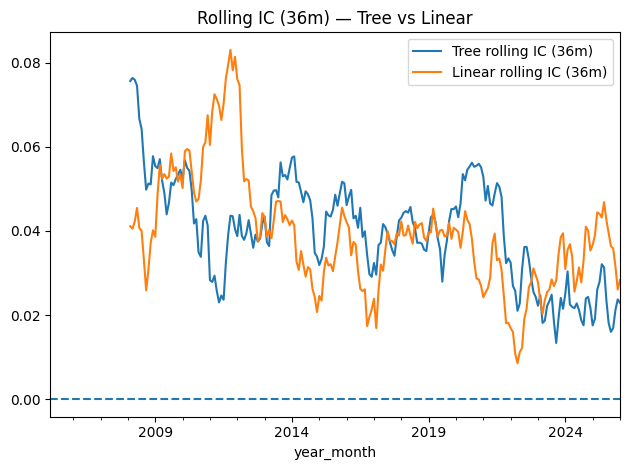

In [16]:
plt.figure()
ic_tree.rolling(36).mean().plot(label="Tree rolling IC (36m)")
ic_linear.rolling(36).mean().plot(label="Linear rolling IC (36m)")
plt.axhline(0, linestyle="--")
plt.title("Rolling IC (36m) — Tree vs Linear")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
os.makedirs("../data/processed", exist_ok=True)
preds_tree.to_parquet("../data/processed/preds_oos_tree.parquet", index=False)
preds_linear.to_parquet("../data/processed/preds_oos_linear.parquet", index=False)

print("Salvo: ../data/processed/preds_oos_tree.parquet")
print("Salvo: ../data/processed/preds_oos_linear.parquet")

Salvo: ../data/processed/preds_oos_tree.parquet
Salvo: ../data/processed/preds_oos_linear.parquet


## Como interpretar IC

- IC > 0 significa que o ranking do modelo está alinhado com retornos futuros.
- Valores típicos em equity:
  - IC médio ~0.01 a 0.05 já pode ser útil
  - IC IR anualizado > 0.5 começa a ficar interessante
- O objetivo aqui é validar se existe **sinal consistente** antes de partir para backtest com custos.